# Route smoothing

Notes on route smoothing.

In [1]:
from wrcapi_rallydj.data_api import WRCDataAPIClient
import pandas as pd

wrc = WRCDataAPIClient(usegeo=True)
r = wrc.get_rallies_data(2025, typ="WRC", as_dict=True)[3] # typ can be ERC, WRC
geostages = wrc.read_kmlfile(r["kmlfile"])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'webappsdata.wrc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


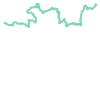

In [2]:
geostages.iloc[2].geometry

## Via claude.ai and chatgpt

In [ ]:
import json
import numpy as np
from scipy.interpolate import CubicSpline
from shapely.geometry import LineString
import osmnx as ox
import geopandas as gpd


def haversine_distance(geojson_data, num_points_between=10, max_distance_threshold=None):
    """
    Smooth a GeoJSON LineString route using cubic splines while preserving original points.
    
    Args:
        geojson_data: Loaded GeoJSON data
        num_points_between: Number of points to interpolate between original points
        max_distance_threshold: If set, only add intermediate points when original points 
                               are farther apart than this distance (in kilometers)
    
    Returns:
        Smoothed GeoJSON data
    """
    # Extract coordinates from GeoJSON
    if isinstance(geojson_data, str):
        geojson_data = json.loads(geojson_data)

    # Handle different possible GeoJSON structures
    if 'features' in geojson_data:
        # It's a FeatureCollection
        coordinates = []
        for feature in geojson_data['features']:
            if feature['geometry']['type'] == 'LineString':
                coordinates.extend(feature['geometry']['coordinates'])
            elif feature['geometry']['type'] == 'Point':
                coordinates.append(feature['geometry']['coordinates'])
    elif 'geometry' in geojson_data:
        # It's a Feature
        coordinates = geojson_data['geometry']['coordinates']
    elif 'coordinates' in geojson_data:
        # It's a Geometry
        coordinates = geojson_data['coordinates']
    else:
        raise ValueError("Unable to extract coordinates from GeoJSON")

    # Ensure coordinates are in the right format
    if not coordinates or len(coordinates) < 3:  # Need at least 3 points for cubic spline
        # Fall back to linear interpolation if not enough points
        return smooth_geojson_route(geojson_data, num_points_between, max_distance_threshold)

    # Extract lon, lat coordinates
    lons = np.array([coord[0] for coord in coordinates])
    lats = np.array([coord[1] for coord in coordinates])

    # Create parameter t based on cumulative distance
    t = [0]
    for i in range(1, len(coordinates)):
        dist = haversine_distance(lats[i-1], lons[i-1], lats[i], lons[i])
        t.append(t[-1] + dist)

    t = np.array(t)

    # Create cubic spline interpolators
    cs_lon = CubicSpline(t, lons)
    cs_lat = CubicSpline(t, lats)

    # Create the smoothed curve by sampling the spline at regular intervals
    smoothed_lons = []
    smoothed_lats = []

    # Ensure original points are included exactly
    original_points = set(tuple(coord) for coord in coordinates)

    # Process the route in segments, preserving original points
    for i in range(len(t) - 1):
        # Add the original starting point for this segment
        smoothed_lons.append(lons[i])
        smoothed_lats.append(lats[i])

        # Check if we need to add intermediate points
        add_intermediate = True
        if max_distance_threshold is not None:
            distance = haversine_distance(lats[i], lons[i], lats[i+1], lons[i+1])
            if distance < max_distance_threshold:
                add_intermediate = False

        if add_intermediate and num_points_between > 0:
            # Sample the spline between these two original points
            segment_ts = np.linspace(t[i], t[i+1], num_points_between + 2)[1:-1]
            for segment_t in segment_ts:
                inter_lon = float(cs_lon(segment_t))
                inter_lat = float(cs_lat(segment_t))
                smoothed_lons.append(inter_lon)
                smoothed_lats.append(inter_lat)

    # Add the final point
    smoothed_lons.append(lons[-1])
    smoothed_lats.append(lats[-1])

    # Create the smoothed coordinate list
    smoothed_coordinates = [[lon, lat] for lon, lat in zip(smoothed_lons, smoothed_lats)]

    # Create a new GeoJSON object with the smoothed coordinates
    if 'features' in geojson_data:
        # Create a new feature with smoothed coordinates
        new_feature = {
            'type': 'Feature',
            'properties': {'smoothed': True},
            'geometry': {
                'type': 'LineString',
                'coordinates': smoothed_coordinates
            }
        }
        result = {
            'type': 'FeatureCollection',
            'features': [new_feature]
        }
    elif 'geometry' in geojson_data:
        # It's a Feature
        result = {
            'type': 'Feature',
            'properties': geojson_data.get('properties', {}),
            'geometry': {
                'type': 'LineString',
                'coordinates': smoothed_coordinates
            }
        }
    else:
        # It's a Geometry
        result = {
            'type': 'LineString',
            'coordinates': smoothed_coordinates
        }

    return result


def enhance_route_resolution_osm(
    geodf, buffer_deg=0.0005, route_simplify_tolerance=None
):
    """
    Enhance route resolution by adding points from OSM road network while PRESERVING the original route points.
    This function will never modify the ground truth points in the original route.

    Args:
        geodf: GeoDataFrame containing LineString geometries representing routes
        buffer_deg: Buffer size in degrees to search for nearby OSM roads
        route_simplify_tolerance: Optional tolerance for simplifying the route after enhancement

    Returns:
        Enhanced GeoDataFrame with more detailed route geometries
    """

    def get_osm_roads_in_bbox(bounds, buffer):
        """Get OSM road network within the bounds of a route"""
        minx, miny, maxx, maxy = bounds
        # Add buffer to ensure we capture nearby roads
        bbox = (
            miny - buffer,  # south
            minx - buffer,  # west
            maxy + buffer,  # north
            maxx + buffer,  # east
        )

        try:
            # Get all highway features as in the original code
            roads = ox.features_from_bbox(bbox, {"highway": True})
            return roads
        except Exception as e:
            print(f"Error fetching OSM data: {e}")
            return None

    def enhance_line(line, roads):
        """Enhance a single LineString with nearby OSM road data while preserving ALL original points"""
        if roads is None or roads.empty:
            return line

        # Extract all valid geometries from the roads
        road_lines = []
        for geom in roads.geometry:
            if geom.geom_type == "LineString":
                road_lines.append(geom)
            elif geom.geom_type == "MultiLineString":
                road_lines.extend(list(geom.geoms))

        if not road_lines:
            return line

        # Create a buffer around our route line
        route_buffer = line.buffer(buffer_deg)

        # Original route points - these are GROUND TRUTH and must be preserved exactly
        original_points = list(line.coords)

        # Enhanced points will include ALL original points plus additional OSM points
        enhanced_points = []

        # For each segment in the original route
        for i in range(len(original_points) - 1):
            # Always add the original start point for this segment
            enhanced_points.append(original_points[i])

            # Create a LineString for this segment
            segment = LineString([original_points[i], original_points[i + 1]])
            segment_buffer = segment.buffer(buffer_deg)

            # Find OSM roads that might provide additional detail for this segment
            additional_points = []
            for road in road_lines:
                if road.intersects(segment_buffer):
                    # Get points from this road segment
                    road_coords = list(road.coords)
                    for pt in road_coords:
                        point = Point(pt)
                        if segment_buffer.contains(point):
                            # Calculate position along the segment (0-1)
                            position = segment.project(point, normalized=True)
                            if (
                                0 < position < 1
                            ):  # Only add points between our original points
                                additional_points.append((position, pt))

            # Sort additional points by position along the segment
            additional_points.sort(key=lambda x: x[0])

            # Add these points to our enhanced route
            if additional_points:
                enhanced_points.extend([pt[1] for pt in additional_points])

        # Always add the final original point
        enhanced_points.append(original_points[-1])

        # Remove any exact duplicates while preserving order
        deduped_points = []
        for pt in enhanced_points:
            if not deduped_points or pt != deduped_points[-1]:
                deduped_points.append(pt)

        # Create new LineString with enhanced points
        enhanced_line = LineString(deduped_points)

        # Optionally simplify but ALWAYS maintain ALL original points
        if route_simplify_tolerance is not None:
            # We need to ensure all original points remain after simplification
            # First simplify to reduce the number of OSM-added points
            simplified = enhanced_line.simplify(
                route_simplify_tolerance, preserve_topology=True
            )

            # Now make sure all original points are included
            simplified_coords = list(simplified.coords)
            final_coords = []

            # Add all original points to the simplified line
            for orig_pt in original_points:
                final_coords.append(orig_pt)

            # Add simplified points that aren't original points
            for simp_pt in simplified_coords:
                if simp_pt not in original_points and (
                    not final_coords or simp_pt != final_coords[-1]
                ):
                    # Find the right position to insert this point
                    for i in range(len(original_points) - 1):
                        segment = LineString(
                            [original_points[i], original_points[i + 1]]
                        )
                        if segment.distance(Point(simp_pt)) < buffer_deg:
                            position = segment.project(Point(simp_pt), normalized=True)
                            # Find where to insert in final_coords
                            for j in range(len(final_coords) - 1):
                                if (
                                    final_coords[j] == original_points[i]
                                    and final_coords[j + 1] == original_points[i + 1]
                                ):
                                    final_coords.insert(j + 1, simp_pt)
                                    break
                            break

            enhanced_line = LineString(final_coords)

        return enhanced_line

    # Process each geometry in the GeoDataFrame
    enhanced_geometries = []

    # Ensure we're working with a GeoDataFrame in WGS84 (EPSG:4326)
    if geodf.crs is None:
        geodf = geodf.set_crs("EPSG:4326")
    elif geodf.crs != "EPSG:4326":
        geodf = geodf.to_crs("EPSG:4326")

    # Process each geometry
    for geom in geodf.geometry:
        if geom.geom_type == "LineString":
            # Get OSM roads around this line
            roads = get_osm_roads_in_bbox(geom.bounds, buffer_deg)
            enhanced_line = enhance_line(geom, roads)
            enhanced_geometries.append(enhanced_line)
        elif geom.geom_type == "MultiLineString":
            # Process each part of the MultiLineString
            enhanced_parts = []
            for part in geom.geoms:
                roads = get_osm_roads_in_bbox(part.bounds, buffer_deg)
                enhanced_part = enhance_line(part, roads)
                enhanced_parts.append(enhanced_part)
            # Keep it as a MultiLineString
            from shapely.geometry import MultiLineString

            enhanced_geometries.append(MultiLineString(enhanced_parts))
        else:
            # For non-line geometries, keep as is
            enhanced_geometries.append(geom)

    # Create a new GeoDataFrame with enhanced geometries
    result = gpd.GeoDataFrame(
        geodf.drop(columns="geometry", errors="ignore"),
        geometry=enhanced_geometries,
        crs="EPSG:4326",
    )

    return result


def smooth_geojson_route(
    route_input, num_points_between=10, max_distance_threshold=None
):
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString
    import json

    def extract_coordinates(route_input):
        if isinstance(route_input, str):
            route_input = json.loads(route_input)
        if isinstance(route_input, dict):  # GeoJSON
            if "features" in route_input:
                return [
                    feature["geometry"]["coordinates"]
                    for feature in route_input["features"]
                ]
            elif "coordinates" in route_input:
                return [route_input["coordinates"]]
        elif isinstance(route_input, gpd.GeoDataFrame):
            return [list(geom.coords) for geom in route_input.geometry]
        elif isinstance(route_input, LineString):
            return [list(route_input.coords)]
        elif isinstance(route_input, list) and all(
            isinstance(pt, (list, tuple)) for pt in route_input
        ):
            return [route_input]  # Single LineString as list of points
        raise ValueError("Unsupported route input format")

    def smooth_coords(coords):
        smoothed = [coords[0]]
        for i in range(1, len(coords)):
            prev = np.array(coords[i - 1])
            curr = np.array(coords[i])
            distance = np.linalg.norm(curr - prev)
            if max_distance_threshold and distance > max_distance_threshold:
                continue  # Skip this segment

            interp_points = [
                (prev + (curr - prev) * t).tolist()
                for t in np.linspace(0, 1, num_points_between + 2)[1:-1]
            ]
            smoothed.extend(interp_points)
            smoothed.append(coords[i])
        return smoothed

    all_coords = extract_coordinates(route_input)
    smoothed_lines = [LineString(smooth_coords(coords)) for coords in all_coords]
    return gpd.GeoDataFrame(geometry=smoothed_lines, crs="EPSG:4326")

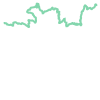

In [8]:
geostages_smooth = smooth_geojson_route(geostages.iloc[2:4])
geostages_smooth.iloc[0].geometry

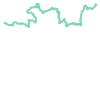

In [9]:
geostages_enhanced = enhance_route_resolution_osm(geostages.iloc[2:4])
geostages_enhanced.iloc[0].geometry

In [13]:
wrc.GeoTools.simple_stage_map(geostages)

Map(center=[np.float64(27.948588968969), np.float64(-15.616814692003)], controls=(ZoomControl(options=['positi…

In [14]:
wrc.GeoTools.simple_stage_map(geostages_enhanced)

Map(center=[np.float64(27.9647048), np.float64(-15.66002975)], controls=(ZoomControl(options=['position', 'zoo…

In [21]:
ox.utils_geo.bbox_from_point((28.0, -15.7), dist=500)

(np.float64(-15.705092716389773),
 np.float64(27.995503398322537),
 np.float64(-15.694907283610226),
 np.float64(28.004496601677463))

In [30]:
import numpy as np
ox.features_from_bbox(
    ox.utils_geo.bbox_from_point((-15.7, 28.0), dist=1500),
    tags={"landuse": True, "building": True, "highway": True},
)

geometry  \
element id                                                              
way     256895775   LINESTRING (28.00728 -15.68916, 28.00757 -15.6...   
        500789335   POLYGON ((28.007 -15.68645, 28.00698 -15.6865,...   
        508719613   POLYGON ((28.00707 -15.68698, 28.00714 -15.686...   
        508720594   POLYGON ((28.00714 -15.68719, 28.00708 -15.687...   
        508720595   POLYGON ((28.007 -15.68701, 28.00704 -15.68703...   
...                                                               ...   
        1094007086  POLYGON ((28.00596 -15.6873, 28.00591 -15.6873...   
        1094007087  POLYGON ((28.00766 -15.6868, 28.00772 -15.6868...   
        1094007088  POLYGON ((28.00785 -15.68651, 28.00781 -15.686...   
        1094007089  POLYGON ((28.00815 -15.68664, 28.00816 -15.686...   
        1094007090  POLYGON ((28.00812 -15.68658, 28.00813 -15.686...   

                         highway  surface building  
element id                                          
way     256895775   unclassified  unpaved      NaN  
        500789335            NaN      NaN      yes  
        508719613            NaN      NaN      yes  
        508720594            NaN      NaN      yes  
        508720595            NaN      NaN      yes  
...                          ...      ...      ...  
        1094007086           NaN      NaN      yes  
        1094007087           NaN      NaN      yes  
        1094007088           NaN      NaN      yes  
        1094007089           NaN      NaN      yes  
        1094007090           NaN      NaN      yes  

[67 rows x 4 columns]